In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import warnings
warnings.filterwarnings("ignore") 
import scipy.stats as st
import scipy.special as ss
from patsy import dmatrix, dmatrices
import statsmodels.formula.api as smf

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 20.2 Data generation

In [2]:
np.random.seed(1234567)
n_site = 150
humidity = np.sort(st.uniform.rvs(-1, 2, size = n_site))
alpha_occ = 0
beta_occ = 3
occ_prob = np.exp(alpha_occ + beta_occ * humidity) / (1 + np.exp(alpha_occ + beta_occ * humidity))

true_presence = st.bernoulli.rvs(p = occ_prob, size = n_site)

alpha_p = 0
beta_p = -5
det_prob = np.exp(alpha_p + beta_p * humidity) / (1 + np.exp(alpha_p + beta_p * humidity))
eff_det_prob = true_presence * det_prob

R = n_site
T = 3
y = np.zeros((R, T))
for i in range(T):
    y[:, i] = st.bernoulli.rvs(p = eff_det_prob, size = n_site)

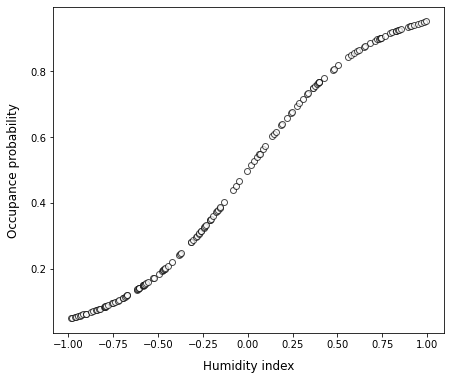

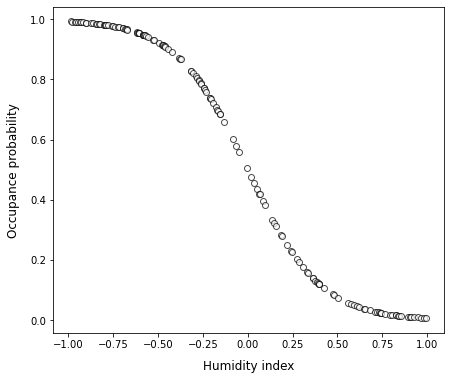

In [3]:
plt.figure(figsize = (7, 6))
plt.scatter(humidity, occ_prob, color="white", ec="black", alpha=0.7)
plt.xlabel('Humidity index', fontsize = 12, labelpad = 10)
plt.ylabel('Occupance probability', fontsize = 12, labelpad = 10)

plt.figure(figsize = (7, 6))
plt.scatter(humidity, det_prob, color="white", ec="black", alpha=0.7)
plt.xlabel('Humidity index', fontsize = 12, labelpad = 10)
plt.ylabel('Occupance probability', fontsize = 12, labelpad = 10);

#### Analysis using a logistic regression

In [4]:
obs = np.where(y.sum(axis = 1) > 0, 1, 0)
data = {'obs': obs, 'humidity': humidity}

In [5]:
naive_analysis = smf.logit("obs ~ humidity", data = data).fit()
print(naive_analysis.summary())

Optimization terminated successfully.
         Current function value: 0.516327
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    obs   No. Observations:                  150
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                            1
Date:                Tue, 02 Aug 2022   Pseudo R-squ.:                0.003884
Time:                        11:25:22   Log-Likelihood:                -77.449
converged:                       True   LL-Null:                       -77.751
Covariance Type:            nonrobust   LLR p-value:                    0.4371
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3391      0.207     -6.478      0.000      -1.744      -0.934
humidity      -0.2673      0.

In [6]:
lin_pred = naive_analysis.params[0] + naive_analysis.params[1] * humidity

### 20.3 Analysis using PyMC3

In [7]:
intercept = np.ones((n_site * T,))
X = np.column_stack((np.ones(150,), humidity))
W = np.repeat(humidity, T)
W_r = np.column_stack((intercept, W))
y_r = y.flatten('C').reshape(-1,1)
yst = np.max(y, axis = 1)
index = np.repeat(np.arange(n_site),T).reshape(-1,1)

In [8]:
with pm.Model() as model_20_3:
    
    #beta = pm.Normal('beta', mu=0, tau = 0.01, shape=(2, 1)) 
    #alpha = pm.Normal('alpha', mu=0, tau = 0.01, shape=(2, 1))
    beta = pm.Uniform('beta', -10, 10, shape=(2, 1)) 
    alpha = pm.Uniform('alpha',-10, 10, shape=(2, 1))
    
    x_b = pm.math.dot(X, beta)
    psi = pm.math.invlogit(x_b).flatten()
    
    w_a = pm.math.dot(W_r, alpha)
    p = pm.Deterministic('p', pm.math.invlogit(w_a))
    
    z = pm.Bernoulli('z', psi, shape = n_site, initval = yst)
    eff_p = z[index] * p

    occ_fs = pm.Deterministic('occ_fs', pm.math.sum(z))
    Presi = pm.Deterministic('Presi', pm.math.abs_(y_r - p))
    fit = pm.Deterministic('fit', pm.math.sum(Presi))
    y_pred = pm.Bernoulli('y_pred', p = eff_p, observed = y_r)
    
    trace_20_3 = pm.sample(3000, tune=1000,  return_inferencedata = True)
    
    y_new = pm.sample_posterior_predictive(trace_20_3)
    data_aux = az.from_pymc3(posterior_predictive = y_new)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [alpha, beta]
>BinaryGibbsMetropolis: [z]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 122 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [9]:
trace_20_3.extend(data_aux)

In [10]:
az.summary(trace_20_3, var_names = ['alpha', 'beta', 'occ_fs', 'fit'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[0, 0]",-0.039,0.282,-0.584,0.471,0.007,0.005,1627.0,2294.0,1.0
"alpha[1, 0]",-5.037,0.775,-6.511,-3.645,0.017,0.012,2184.0,2599.0,1.0
"beta[0, 0]",0.088,0.421,-0.708,0.873,0.016,0.011,729.0,1389.0,1.0
"beta[1, 0]",2.655,0.865,0.968,4.198,0.032,0.023,704.0,1465.0,1.0
occ_fs,67.842,6.815,55.000,79.000,0.269,0.191,640.0,1216.0,1.0
fit,231.367,7.525,217.844,245.877,0.184,0.130,1677.0,2644.0,1.0


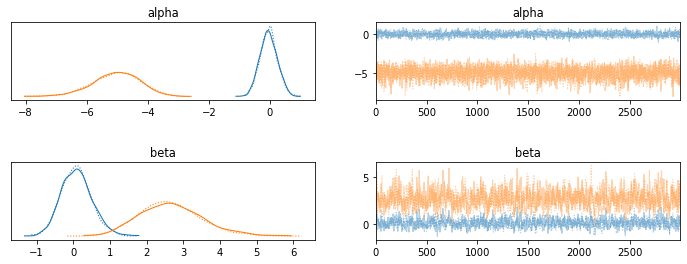

In [11]:
az.plot_trace(trace_20_3, var_names = ['alpha', 'beta']);
plt.subplots_adjust(hspace = 0.8, wspace=0.2);

In [12]:
Presi = trace_20_3.posterior.stack(samples = {'chain', 'draw', 'Presi_dim_1'})['Presi'].values
p_post = trace_20_3.posterior.stack(samples = {'chain', 'draw', 'p_dim_1'})['p'].values # 
y_ppc = trace_20_3.posterior_predictive.stack(samples = {'chain', 'draw', 'y_pred_dim_1'})['y_pred'].values 
fit = trace_20_3.posterior.stack(samples = {'chain', 'draw', 'Presi_dim_1'})['fit'].values

In [13]:
Presi_new = np.abs(y_ppc - p_post).mean(axis = 1)
fit_new = np.sum(Presi_new)
print(fit_new)
bpvalue = (Presi_new > Presi.mean(axis = 1)).mean()
print('Bayesian p-value =', bpvalue)

229.64248667288933
Bayesian p-value = 0.4577777777777778


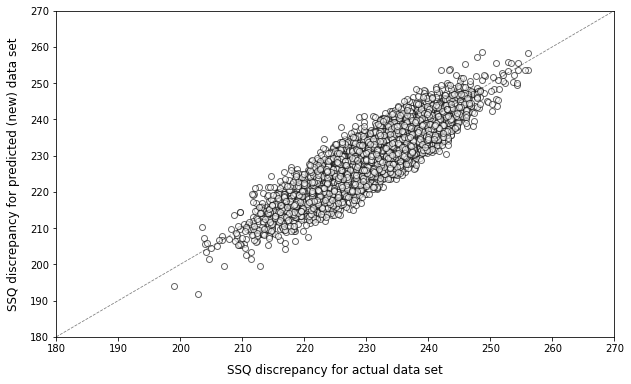

In [14]:
plt.figure(figsize = (10,6))
plt.axline((10, 10), ls = '--', color = 'k', slope=1, alpha = 0.5, lw = 0.8)
plt.scatter(fit, np.abs(y_ppc - p_post).sum(axis = 0), edgecolor = 'k', facecolor = 'white', alpha = 0.6)
plt.xlabel('SSQ discrepancy for actual data set', fontsize = 12, labelpad = 10)
plt.ylabel('SSQ discrepancy for predicted (new) data set', fontsize = 12, labelpad = 10)
plt.ylim(180, 270)
plt.xlim(180, 270);

**FIGURE 20.6**

In [15]:
alpha_occ_pred, beta_occ_pred = trace_20_3.posterior.stack(samples = {'chain', 'draw', 'beta_dim_1'})['beta'].values.mean(axis = 1)
lin_pred2 = alpha_occ_pred + beta_occ_pred * humidity

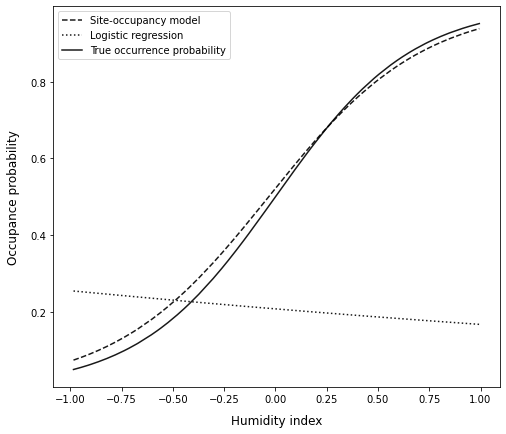

In [16]:
plt.figure(figsize = (8, 7))
plt.plot(humidity, np.exp(lin_pred2) / (1 + np.exp(lin_pred2)), ls = '--', color = 'black', alpha=0.9, label = 'Site-occupancy model')
plt.plot(humidity, np.exp(lin_pred) / (1 + np.exp(lin_pred)), ls = ':', color = 'black', alpha=0.9, label = 'Logistic regression')
plt.plot(humidity, occ_prob, ls = '-', color = 'black', alpha=0.9, label = 'True occurrence probability')
plt.xlabel('Humidity index', fontsize = 12, labelpad = 10)
plt.ylabel('Occupance probability', fontsize = 12, labelpad = 10)
plt.legend(loc = 'upper left');
